In [1]:
import numpy as np
from numpy import argmax
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
%matplotlib inline

##### Set Constant #####
path = '/data/examples/may_the_4_be_with_u/show_me_the_money/'

In [2]:
# load training and testing set, 'Fraud' is the field to predict
train = pd.read_csv(filepath_or_buffer = path+'train.csv')
test = pd.read_csv(filepath_or_buffer = path+'test.csv')
# id of the testing set
test_id = test.id -1

In [3]:
train.head()

,id,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,Fraud
0,0,323,PAYMENT,9092.69,C749189758,0.0,0.00,M1939669337,0.00,0.00,0.0
1,1,164,CASH_IN,23468.75,C525009948,0.0,23468.75,C65353523,77300.17,53831.42,0.0
2,2,228,CASH_OUT,39688.11,C1311063915,0.0,0.00,C1581032686,168913.26,208601.37,0.0
3,3,229,CASH_OUT,179016.96,C700594269,103485.0,0.00,C90149178,2483034.47,2662051.42,0.0
4,4,709,CASH_OUT,77155.99,C646560157,143307.0,66151.01,C671337546,21213865.83,21291021.82,0.0


In [4]:
test.head()

,id,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,329,PAYMENT,41909.68,C1965438439,18391.00,0.00,M296912999,0.00,0.00
1,2,205,CASH_IN,57645.11,C2061644565,3162376.19,3220021.31,C2046839454,701205.57,643617.16
2,3,299,PAYMENT,41911.35,C630506216,9218.00,0.00,M1895361660,0.00,0.00
3,4,165,PAYMENT,10297.71,C1059151844,29739.00,19441.29,M830221248,0.00,0.00
4,5,346,TRANSFER,143577.58,C1707397780,115.00,0.00,C1234376661,1184548.85,1328126.42


In [5]:
set(train.columns) - set(test.columns)

{'Fraud'}

In [6]:
print(train.shape, test.shape)

(3817572, 11) (2545047, 10)


In [7]:
#Save the 'Id' column
train_ID = train['id']
#test_ID = test['id']
y_label = train.Fraud.values
#Drop the 'Id'
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

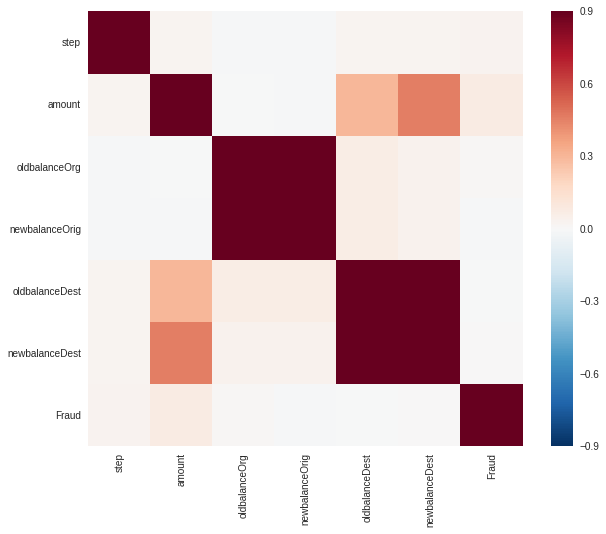

In [8]:
corrmat = train.corr()
plt.subplots(figsize=(10,8))
sns.set(rc={'figure.facecolor' : 'grey'})
sns.heatmap(corrmat, vmax=0.9, square=True)

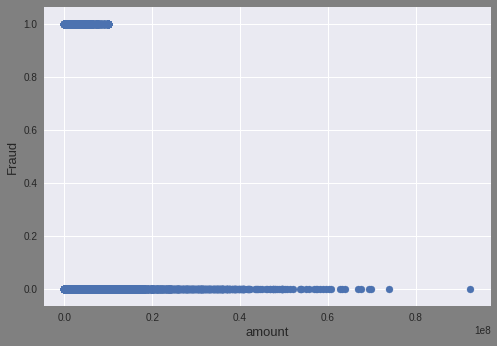

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = train['amount'], y = train['Fraud'])
plt.ylabel('Fraud', fontsize=13)
plt.xlabel('amount', fontsize=13)
plt.show()

In [8]:
#y_train = train.Fraud.values
# concat training & testing sets
all_data = pd.concat((train, test)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (6362619, 10)


In [6]:
all_data.head()

,Fraud,amount,nameDest,nameOrig,newbalanceDest,newbalanceOrig,oldbalanceDest,oldbalanceOrg,step,type
0,0.0,9092.69,M1939669337,C749189758,0.00,0.00,0.00,0.0,323,PAYMENT
1,0.0,23468.75,C65353523,C525009948,53831.42,23468.75,77300.17,0.0,164,CASH_IN
2,0.0,39688.11,C1581032686,C1311063915,208601.37,0.00,168913.26,0.0,228,CASH_OUT
3,0.0,179016.96,C90149178,C700594269,2662051.42,0.00,2483034.47,103485.0,229,CASH_OUT
4,0.0,77155.99,C671337546,C646560157,21291021.82,66151.01,21213865.83,143307.0,709,CASH_OUT


In [ ]:
print('\n The types of fraudulent transactions are {}'.format(\
list(train.loc[train.Fraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = train.loc[(train.Fraud == 1) & (train.type == 'TRANSFER')]
dfFraudCashout = train.loc[(train.Fraud == 1) & (train.type == 'CASH_OUT')]
dfFraudCashin = train.loc[(train.Fraud == 1) & (train.type == 'CASH_IN')]
dfFraudPay = train.loc[(train.Fraud == 1) & (train.type == 'PAYMENT')]
dfFraudDebit = train.loc[(train.Fraud == 1) & (train.type == 'DEBIT')]
print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097
print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116
print ('\n The number of fraudulent CASH_INs = {}'.\
       format(len(dfFraudCashin))) # 0
print ('\n The number of fraudulent PAYMENTs = {}'.\
       format(len(dfFraudPay))) # 0
print ('\n The number of fraudulent =DEBITs = {}'.\
       format(len(dfFraudDebit))) # 0

In [10]:
trans_type = pd.get_dummies(all_data['type'])
trans_type.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [11]:
all_data = pd.concat([all_data, trans_type], axis=1).fillna(0)

In [ ]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0 => {}'.\
format(len(all_data.loc[(all_data.Fraud == 0) & \
(all_data.oldbalanceDest == 0) & (all_data.newbalanceDest == 0)])))

In [ ]:
amount_mean = train['amount'].mean()
print(amount_mean)

In [ ]:
X_od_zero = train.loc[train['oldbalanceDest'] == 0]
X_nd_zero = train.loc[train['newbalanceDest'] == 0]

In [ ]:
X_oo_zero = train.loc[train['oldbalanceOrg'] == 0]
X_no_zero = train.loc[train['newbalanceOrig'] == 0]

In [ ]:
isFraud = train[(train['Fraud']==1)]
isFraud.shape

In [ ]:
testFraud = train[(train['Fraud']==1) & (train['newbalanceOrig']> amount_mean)]
testFraud.shape

In [12]:
all_data.loc[(all_data['oldbalanceDest'] == 0) & (all_data['newbalanceDest'] == 0) & (all_data['amount'] != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1

In [13]:
all_data.loc[(all_data['oldbalanceOrg'] == 0) & (all_data['newbalanceOrig'] == 0) & (all_data['amount'] != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan

In [ ]:
#print(train.shape, test.shape, y_label.shape)

In [14]:
all_data['errorBalanceOrig'] = all_data['newbalanceOrig'] + all_data['amount'] - all_data['oldbalanceOrg']
all_data['errorBalanceDest'] = all_data['oldbalanceDest'] + all_data['amount'] - all_data['newbalanceDest']

In [15]:
all_data.drop('CASH_IN', axis=1, inplace=True)
all_data.drop('PAYMENT', axis=1, inplace=True)
all_data.drop('DEBIT', axis=1, inplace=True)
all_data.drop(['Fraud'], axis=1, inplace=True)

In [16]:
all_data = all_data.fillna(-1)
all_data.head()

,amount,nameDest,nameOrig,newbalanceDest,newbalanceOrig,oldbalanceDest,oldbalanceOrg,step,type,CASH_OUT,TRANSFER,errorBalanceOrig,errorBalanceDest
0,9092.69,M1939669337,C749189758,-1.00,-1.00,-1.00,-1.0,323,PAYMENT,0,0,-1.00,9.092690e+03
1,23468.75,C65353523,C525009948,53831.42,23468.75,77300.17,0.0,164,CASH_IN,0,0,46937.50,4.693750e+04
2,39688.11,C1581032686,C1311063915,208601.37,-1.00,168913.26,-1.0,228,CASH_OUT,1,0,-1.00,0.000000e+00
3,179016.96,C90149178,C700594269,2662051.42,0.00,2483034.47,103485.0,229,CASH_OUT,1,0,75531.96,1.000000e-02
4,77155.99,C671337546,C646560157,21291021.82,66151.01,21213865.83,143307.0,709,CASH_OUT,1,0,0.00,-3.725290e-09


In [15]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats.head(20)

amount              30.993940
errorBalanceOrig    20.044599
oldbalanceDest      19.921750
newbalanceDest      19.352295
oldbalanceOrg        5.249140
newbalanceOrig       5.176888
TRANSFER             3.005133
CASH_OUT             0.621319
step                 0.375177
errorBalanceDest   -49.202264
dtype: float64

In [ ]:
sns.distplot(all_data['amount'], fit=norm);
fig = plt.figure()
res = stats.probplot(all_data['amount'], plot=plt)

In [17]:
train = all_data[:train.shape[0]]
test = all_data[train.shape[0]:]

In [18]:
print(train.shape, test.shape)

(3817572, 13) (2545047, 13)


In [19]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
print(numeric_feats)

Index(['amount', 'newbalanceDest', 'newbalanceOrig', 'oldbalanceDest',
       'oldbalanceOrg', 'step', 'CASH_OUT', 'TRANSFER', 'errorBalanceOrig',
       'errorBalanceDest'],
      dtype='object')


In [20]:
numeric_feats_test = test.dtypes[test.dtypes != "object"].index
print(numeric_feats_test)

Index(['amount', 'newbalanceDest', 'newbalanceOrig', 'oldbalanceDest',
       'oldbalanceOrg', 'step', 'CASH_OUT', 'TRANSFER', 'errorBalanceOrig',
       'errorBalanceDest'],
      dtype='object')


In [21]:
num_train = train[numeric_feats]
#num_train = num_train.drop('Fraud', axis=1)
num_test = test[numeric_feats_test]

In [22]:
set(num_train.columns) - set(num_test.columns)

set()

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(num_train, y_label, test_size=0.2, random_state=0)

In [152]:
model = XGBClassifier(
    colsample_bytree= 1,
    learning_rate= 0.07,
    max_depth= 15,
    min_child_weight= 16,
    n_estimators= 1000,
    nthread= 4,
    objective= 'binary:logistic',
    seed= 1337,
    silent= True,
    subsample= 1)

In [153]:
model.fit(X_train, Y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=[(X_test, Y_test)],
         verbose=True)

[0]	validation_0-auc:0.918291
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.918369
[2]	validation_0-auc:0.918695
[3]	validation_0-auc:0.921476
[4]	validation_0-auc:0.985922
[5]	validation_0-auc:0.985873
[6]	validation_0-auc:0.986123
[7]	validation_0-auc:0.986128
[8]	validation_0-auc:0.986122
[9]	validation_0-auc:0.986121
[10]	validation_0-auc:0.986198
[11]	validation_0-auc:0.986371
[12]	validation_0-auc:0.991695
[13]	validation_0-auc:0.992282
[14]	validation_0-auc:0.992282
[15]	validation_0-auc:0.992497
[16]	validation_0-auc:0.992778
[17]	validation_0-auc:0.999087
[18]	validation_0-auc:0.999087
[19]	validation_0-auc:0.999088
[20]	validation_0-auc:0.999088
[21]	validation_0-auc:0.999089
[22]	validation_0-auc:0.999087
[23]	validation_0-auc:0.999088
[24]	validation_0-auc:0.999086
[25]	validation_0-auc:0.999086
[26]	validation_0-auc:0.999086
[27]	validation_0-auc:0.999086
[28]	validation_0-auc:0.999087
[29]	validation_0-auc:0.999238
[30]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.075, max_delta_step=0,
       max_depth=15, min_child_weight=16, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337,
       silent=True, subsample=1)

In [154]:
predict = model.predict_proba(num_test)

In [155]:
print(predict[:,1])

[ 0.00096655  0.00096626  0.00096655 ...,  0.00098185  0.00097931
  0.00096676]


In [156]:
test_id.head()

0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64

In [157]:
df = pd.DataFrame( {"Id": test_id, "Fraud": pd.Series(predict[:,1])} )
df = df[['Id', 'Fraud']]

In [159]:
#df[(df['Fraud']>0.5)].head()
df.to_csv('submission.csv', index = False)
#df.loc[df['Fraud'] >= 0.5].head()

In [54]:
xgb_model = XGBClassifier()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.07], #so called `eta` value
              'max_depth': [14],
              'min_child_weight': [16,17],
              'silent': [1],
              'subsample': [1],
              'colsample_bytree': [1],
              'n_estimators': [150], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

In [ ]:
clf = GridSearchCV(xgb_model, parameters, n_jobs=1, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=2, refit=True)
clf.fit(X_train, Y_train)

In [43]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
#rForest = RandomForestClassifier(n_estimators=1000, learning_rate=0.05,
#                                   max_depth=4, max_features='sqrt',
#                                   min_samples_leaf=15, min_samples_split=10, 
#                                   loss='exponential', random_state =5)

In [ ]:
#score = rmsle_cv(GBoost)
#print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))